# Nonlocality study for CMSP

Let's see how localized certain skills are to neurons. And how does this change with width?

In [1]:
#!/usr/bin/env python
# coding: utf-8
"""
This script trains MLPs on multiple sparse parity problems at once,
including composite tasks.
"""

from typing import Dict, List, Callable
import argparse
from collections import defaultdict
from itertools import islice
import copy
import json
import pickle
import os

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import torch
import torch.nn as nn

/om2/user/ericjm/miniconda3/envs/narrow/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def visualize_mlp(model, weight_threshold=0.3, color_range=[-1, 1], s=10, ax=None):
    
    assert isinstance(model, nn.Sequential), "Model must be nn.Sequential"
    layers = [module for module in model if isinstance(module, nn.Linear)]
    
    # Use provided axis or create a new one
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
    
    # Determine maximum neuron count in any layer for plotting bounds
    max_width = max(
        max(layer.in_features, layer.out_features) for layer in layers
    )
    ax.set_xlim(-max_width * 0.05, max_width * 1.05)
    ax.set_ylim(-0.2, len(layers) + 0.2)
    
    # Compute positions for neurons in each layer
    positions = []
    for i, layer in enumerate(layers):
        pos = np.linspace(0, max_width - 1, layer.in_features)
        positions.append(pos)
    # Positions for neurons in the final layer
    positions.append(np.linspace(0, max_width - 1, layers[-1].out_features))
    
    # Plot the neurons as black dots
    for i, layer in enumerate(layers):
        ax.scatter(positions[i], [i] * layer.in_features, s=s, c='black', zorder=10)
    ax.scatter(positions[-1], [len(layers)] * layers[-1].out_features, s=s, c='black', zorder=10)
    
    # Plot the connections with constant line thickness
    for i, layer in enumerate(layers):
        weights = layer.weight.detach().cpu().numpy()
        for j in range(layer.in_features):
            for k in range(layer.out_features):
                weight = weights[k, j]
                if abs(weight) > weight_threshold:
                    color = plt.cm.bwr((weight - color_range[0]) / (color_range[1] - color_range[0]))
                    ax.plot(
                        [positions[i][j], positions[i+1][k]],
                        [i, i+1],
                        c=color,
                        linewidth=2,  # constant thickness
                        alpha=0.7
                    )

In [3]:
# single perfect mega-plot

def load_mlp(width, seed=0, regularized=False, device=None):
    depth = 3
    n = 18
    n_tasks = 6
    activation = "ReLU"
    layernorm = False
    dtype = torch.float32
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if activation == "ReLU":
        activation_fn = nn.ReLU
    elif activation == "Tanh":
        activation_fn = nn.Tanh
    else:
        activation_fn = nn.Sigmoid
    layers = []
    for i in range(depth):
        if i == 0:
            if layernorm:
                layers.append(nn.LayerNorm(n_tasks + n))
            layers.append(nn.Linear(n_tasks + n, width))
            layers.append(activation_fn())
        elif i == depth - 1:
            if layernorm:
                layers.append(nn.LayerNorm(width))
            layers.append(nn.Linear(width, 2))
        else:
            if layernorm:
                layers.append(nn.LayerNorm(width))
            layers.append(nn.Linear(width, width))
            layers.append(activation_fn())
    mlp = nn.Sequential(*layers).to(dtype).to(device)
    if not regularized:
        mlp.load_state_dict(torch.load(f"../experiments/compositions3/results/width{width}/seed{seed}/model.pt", map_location=device))
    else:
        mlp.load_state_dict(torch.load(f"../experiments/compositions3/results/width{width}/seed{seed}/model_regularized.pt", map_location=device))
    return mlp

def get_pruning_results(width, seed=0, regularized=False):
    # load up data
    if not regularized:
        with open(f'../experiments/compositions3/results/width{width}/seed{seed}/ablation_results.pkl', 'rb') as f:
            ablation_results = pickle.load(f)
        with open(f"../experiments/compositions3/results/width{width}/seed{seed}/sparsities.pkl", 'rb') as f:
            sparsities = pickle.load(f)
    else:
        with open(f'../experiments/compositions3/results/width{width}/seed{seed}/ablation_results_regularization.pkl', 'rb') as f:
            ablation_results = pickle.load(f)
        with open(f"../experiments/compositions3/results/width{width}/seed{seed}/sparsities.pkl", 'rb') as f:
            sparsities = pickle.load(f)
    x = np.array(sparsities)
    y1 = np.array(ablation_results['accuracies_ablation'])
    y2 = np.array(ablation_results['accuracies_ablation_othertask'])
    y3 = np.array(ablation_results['accuracies_recovery_ablation'])
    y4 = np.array(ablation_results['accuracies_recovery_othertask'])
    u = -np.log10(1 - x)
    return u, y1, y2, y3, y4

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
mlp64 = load_mlp(64, device=device)
mlp64_regularized = load_mlp(64, regularized=True, device=device)
mlp128 = load_mlp(128, device=device)
mlp128_regularized = load_mlp(128, regularized=True, device=device)
mlp256 = load_mlp(256, device=device)
mlp256_regularized = load_mlp(256, regularized=True, device=device)
mlp512 = load_mlp(512, device=device)
mlp512_regularized = load_mlp(512, regularized=True, device=device)
mlp1024 = load_mlp(1024, device=device)
mlp1024_regularized = load_mlp(1024, regularized=True, device=device)

/tmp/ipykernel_2749726/1740229514.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp.load_state_dict(torch.load(f"../experiments/compositions3/results/width{width}/see

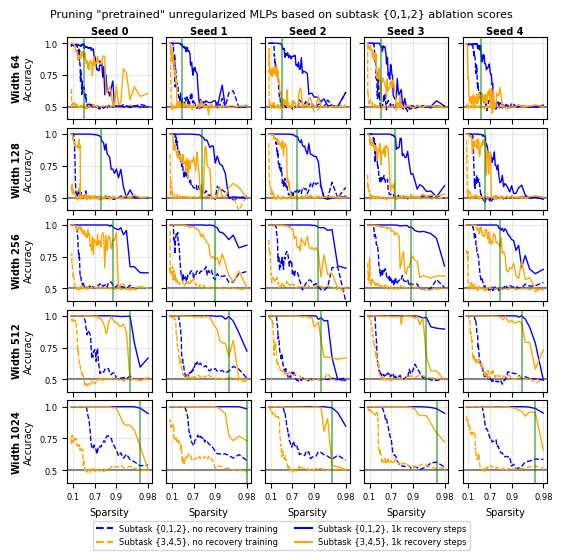

In [9]:
widths = [64, 128, 256, 512, 1024]
seeds  = [0, 1, 2, 3, 4]

fig = plt.figure(figsize=(5.5, 5.5))
i = 1
for width in widths:
    for seed in seeds:
        ax = plt.subplot(len(widths), len(seeds), i)
        u, y1, y2, y3, y4 = get_pruning_results(width, seed=seed)
        ax.plot(u, y1, label='Subtask [1,2,3], no recovery training',
                color='blue', linestyle='--', linewidth=1)
        ax.plot(u, y2, label='Subtask [4,5,6], no recovery training',
                color='orange', linestyle='--', linewidth=1)
        ax.plot(u, y3, label='Subtask [1,2,3], 1k recovery steps',
                color='blue', linewidth=1)
        ax.plot(u, y4, label='Subtask [4,5,6], 1k recovery steps',
                color='orange', linewidth=1)
        ax.axhline(0.5, color='black', alpha=0.5, zorder=-5)

        u_values = u[y3 >= 0.98]
        if len(u_values) > 0:
            ax.axvline(u_values[-1], color='green', alpha=0.5, zorder=5)

        desired = [0.1, 0.7, 0.9, 0.98]
        u_ticks = -np.log10(1 - np.array(desired))
        ax.set_xticks(u_ticks)
        if width == 1024:
            ax.set_xlabel('Sparsity', fontsize=7)
            ax.set_xticklabels([str(d) for d in desired], fontsize=6)
        else:
            ax.set_xticklabels([])

        if seed == 0:
            # bold only the "Width <n>" part via mathtext, normal "Accuracy"
            label = rf"$\mathbf{{Width\ {width}}}$" + "\nAccuracy"
            ax.set_ylabel(label, fontsize=7)
            ax.set_yticks([0.5, 0.75, 1.0])
            ax.set_yticklabels([str(d) for d in [0.5, 0.75, 1.0]], fontsize=6)
        else:
            ax.set_yticklabels([])

        # only top row gets a seed-title, and make it bold
        if width == widths[0]:
            ax.set_title(f"Seed {seed}", fontsize=7, pad=2, fontweight='bold')
        else:
            ax.set_title("")

        ax.set_ylim(0.4, 1.05)
        ax.grid(True, alpha=0.3)
        i += 1

# legend (unchanged)
legend_handles = [
    Line2D([0], [0], color='blue',   linestyle='--'),
    Line2D([0], [0], color='orange', linestyle='--'),
    Line2D([0], [0], color='blue',   linestyle='-'),
    Line2D([0], [0], color='orange', linestyle='-'),
]
legend_labels = [
    'Subtask {0,1,2}, no recovery training',
    'Subtask {3,4,5}, no recovery training',
    'Subtask {0,1,2}, 1k recovery steps',
    'Subtask {3,4,5}, 1k recovery steps',
]
fig.legend(legend_handles, legend_labels,
           loc='lower center', ncol=2, frameon=True, fontsize=6)

plt.suptitle(
    'Pruning "pretrained" unregularized MLPs based on subtask {0,1,2} ablation scores',
    fontsize=8
)
plt.tight_layout(pad=0.25, rect=[0, 0.05, 1, 0.98])
plt.savefig('figures/pruningresultspretrainedacrosswidthandseed.pdf')

/tmp/ipykernel_2749726/1740229514.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp.load_state_dict(torch.load(f"../experiments/compositions3/results/width{width}/see

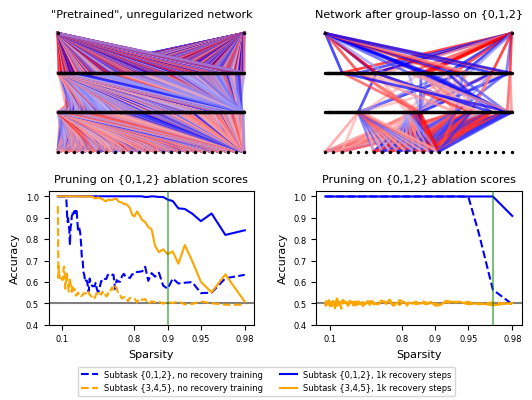

In [16]:
fig = plt.figure(figsize=(5.5, 4))

width = 256
seed = 1

mlp = load_mlp(width, seed=seed)
mlp_regularized = load_mlp(width, regularized=True, seed=seed)

ax = plt.subplot(2, 2, 1)
visualize_mlp(mlp, ax=ax, s=2)
ax.axis('off')
ax.set_title(f'"Pretrained", unregularized network', fontsize=8)

ax = plt.subplot(2, 2, 2)
visualize_mlp(mlp_regularized, ax=ax, s=2)
ax.axis('off')
ax.set_title(f"Network after group-lasso on {{0,1,2}}", fontsize=8)

ax = plt.subplot(2, 2, 3)
u, y1, y2, y3, y4 = get_pruning_results(width, seed=seed)
ax.plot(u, y1, label='Subtask {0,1,2}, no recovery training',
        color='blue', linestyle='--')
ax.plot(u, y2, label='Subtask {3,4,5}, no recovery training',
        color='orange', linestyle='--')
ax.plot(u, y3, label='Subtask {0,1,2}, 1k recovery steps',
        color='blue')
ax.plot(u, y4, label='Subtask {3,4,5}, 1k recovery steps',
        color='orange')
ax.axhline(0.5, color='black', alpha=0.5, zorder=-5)

u_values = u[y3 >= 0.98]
if len(u_values) > 0:
    ax.axvline(u_values[-1], color='green', alpha=0.5, zorder=5)

desired = [0.1, 0.8, 0.9, 0.95, 0.98]
u_ticks = -np.log10(1 - np.array(desired))
ax.set_xticks(u_ticks)
ax.set_xticklabels([str(d) for d in desired], fontsize=6)

ax.set_xlabel('Sparsity', fontsize=8)
ax.set_ylabel('Accuracy', fontsize=8)
ax.tick_params(axis='y', labelsize=6) # Make y-axis tick labels smaller
ax.set_title("Pruning on {0,1,2} ablation scores", fontsize=8)
# ax.legend(loc='lower left', prop={'size': 3})
ax.set_ylim(0.4, None)


ax = plt.subplot(2, 2, 4)
u, y1, y2, y3, y4 = get_pruning_results(width, regularized=True, seed=seed)
ax.plot(u, y1, label='Subtask {0,1,2}, no recovery training',
        color='blue', linestyle='--')
ax.plot(u, y2, label='Subtask {3,4,5}, no recovery training',
        color='orange', linestyle='--')
ax.plot(u, y3, label='Subtask {0,1,2}, 1k recovery steps',
        color='blue')
ax.plot(u, y4, label='Subtask {3,4,5}, 1k recovery steps',
        color='orange')
ax.axhline(0.5, color='black', alpha=0.5, zorder=-5)

u_values = u[y3 >= 0.98]
if len(u_values) > 0:
    ax.axvline(u_values[-1], color='green', alpha=0.5, zorder=5)

desired = [0.1, 0.8, 0.9, 0.95, 0.98]
u_ticks = -np.log10(1 - np.array(desired))
ax.set_xticks(u_ticks)
ax.set_xticklabels([str(d) for d in desired], fontsize=6)

ax.set_xlabel('Sparsity', fontsize=8)
ax.set_ylabel('Accuracy', fontsize=8)
ax.tick_params(axis='y', labelsize=6) # Make y-axis tick labels smaller
ax.set_title("Pruning on {0,1,2} ablation scores", fontsize=8)
# ax.legend(loc='lower left', prop={'size': 3})
ax.set_ylim(0.4, None)

# legend
legend_handles = [
    Line2D([0], [0], color='blue',   linestyle='--'),
    Line2D([0], [0], color='orange', linestyle='--'),
    Line2D([0], [0], color='blue',   linestyle='-'),
    Line2D([0], [0], color='orange', linestyle='-'),
]
legend_labels = [
    'Subtask {0,1,2}, no recovery training',
    'Subtask {3,4,5}, no recovery training',
    'Subtask {0,1,2}, 1k recovery steps',
    'Subtask {3,4,5}, 1k recovery steps',
]
fig.legend(legend_handles, legend_labels,
           loc='lower center', ncol=2, frameon=True, fontsize=6)

fig.subplots_adjust(wspace=20.0)
plt.tight_layout(rect=[0, 0.05, 1, 1]) # Adjust layout to make space for legend
plt.savefig('figures/cmspnetworkstructureandpruningresultsmain.png', dpi=300)

(0.4, 1.0258000001311303)

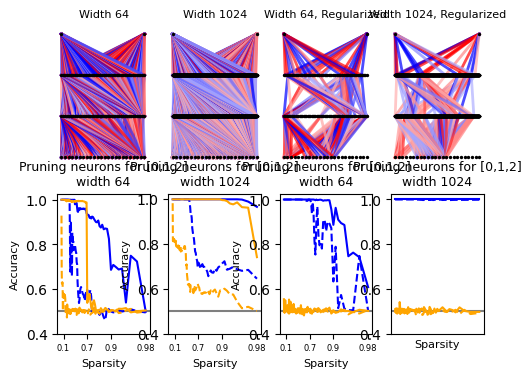

In [ ]:
plt.figure(figsize=(5.5, 4))

ax = plt.subplot(2, 4, 1)
visualize_mlp(mlp64, ax=ax, s=2)
ax.axis('off')
ax.set_title("Width 64", fontsize=8)
ax = plt.subplot(2, 4, 2)
# visualize_mlp(mlp512, ax=ax, s=2)
visualize_mlp(mlp256, ax=ax, s=2)
ax.axis('off')
ax.set_title("Width 1024", fontsize=8)
ax = plt.subplot(2, 4, 3)
visualize_mlp(mlp64_regularized, ax=ax, s=2)
ax.axis('off')
ax.set_title("Width 64, Regularized", fontsize=8)
ax = plt.subplot(2, 4, 4)
visualize_mlp(mlp1024_regularized, ax=ax, s=2)
ax.axis('off')
ax.set_title("Width 1024, Regularized", fontsize=8)



ax = plt.subplot(2, 4, 5)
width = 64
u, y1, y2, y3, y4 = get_pruning_results(width)
ax.plot(u, y1, label='Subtask [1,2,3], no recovery training',
        color='blue', linestyle='--')
ax.plot(u, y2, label='Subtask [4,5,6], no recovery training',
        color='orange', linestyle='--')
ax.plot(u, y3, label='Subtask [1,2,3], 1k recovery steps',
        color='blue')
ax.plot(u, y4, label='Subtask [4,5,6], 1k recovery steps',
        color='orange')
ax.axhline(0.5, color='black', alpha=0.5, zorder=-5)
desired = [0.1, 0.7, 0.9, 0.98]
u_ticks = -np.log10(1 - np.array(desired))
ax.set_xticks(u_ticks)
ax.set_xticklabels([str(d) for d in desired], fontsize=6)

ax.set_xlabel('Sparsity', fontsize=8)
ax.set_ylabel('Accuracy', fontsize=8)
ax.set_title(f"Pruning neurons for [0,1,2]\nwidth {width}", fontsize=9)
# ax.legend(loc='lower left', prop={'size': 3})
ax.set_ylim(0.4, None)



ax = plt.subplot(2, 4, 6)
width = 1024
u, y1, y2, y3, y4 = get_pruning_results(width)
ax.plot(u, y1, label='Subtask [1,2,3], no recovery training',
        color='blue', linestyle='--')
ax.plot(u, y2, label='Subtask [4,5,6], no recovery training',
        color='orange', linestyle='--')
ax.plot(u, y3, label='Subtask [1,2,3], 1k recovery steps',
        color='blue')
ax.plot(u, y4, label='Subtask [4,5,6], 1k recovery steps',
        color='orange')
ax.axhline(0.5, color='black', alpha=0.5, zorder=-5)
desired = [0.1, 0.7, 0.9, 0.98]
u_ticks = -np.log10(1 - np.array(desired))
ax.set_xticks(u_ticks)
ax.set_xticklabels([str(d) for d in desired], fontsize=6)

ax.set_xlabel('Sparsity', fontsize=8)
ax.set_ylabel('Accuracy', fontsize=8)
ax.set_title(f"Pruning neurons for [0,1,2]\nwidth {width}", fontsize=9)
# ax.legend(loc='lower left', prop={'size': 3})
ax.set_ylim(0.4, None)



ax = plt.subplot(2, 4, 7)
width = 64  
u, y1, y2, y3, y4 = get_pruning_results(width, regularized=True)
ax.plot(u, y1, label='Subtask [1,2,3], no recovery training',
        color='blue', linestyle='--')
ax.plot(u, y2, label='Subtask [4,5,6], no recovery training',
        color='orange', linestyle='--')
ax.plot(u, y3, label='Subtask [1,2,3], 1k recovery steps',
        color='blue')
ax.plot(u, y4, label='Subtask [4,5,6], 1k recovery steps',
        color='orange')
ax.axhline(0.5, color='black', alpha=0.5, zorder=-5)
desired = [0.1, 0.7, 0.9, 0.98]
u_ticks = -np.log10(1 - np.array(desired))
ax.set_xticks(u_ticks)
ax.set_xticklabels([str(d) for d in desired], fontsize=6)

ax.set_xlabel('Sparsity', fontsize=8)
ax.set_ylabel('Accuracy', fontsize=8)
ax.set_title(f"Pruning neurons for [0,1,2]\nwidth {width}", fontsize=9)
# ax.legend(loc='lower left', prop={'size': 3})
ax.set_ylim(0.4, None)



ax = plt.subplot(2, 4, 8)
width = 1024
u, y1, y2, y3, y4 = get_pruning_results(width, regularized=True)
ax.plot(u, y1, label='Subtask [1,2,3], no recovery training',
        color='blue', linestyle='--')
ax.plot(u, y2, label='Subtask [4,5,6], no recovery training',
        color='orange', linestyle='--')
ax.plot(u, y3, label='Subtask [1,2,3], 1k recovery steps',
        color='blue')
ax.plot(u, y4, label='Subtask [4,5,6], 1k recovery steps',
        color='orange')
ax.axhline(0.5, color='black', alpha=0.5, zorder=-5)
desired = [0.1, 0.7, 0.9, 0.98]
u_ticks = -np.log10(1 - np.array(desired))
ax.set_xticks([])
ax.set_xticklabels([])

ax.set_xlabel('Sparsity', fontsize=8)
# ax.set_ylabel('Accuracy', fontsize=8)
ax.set_title(f"Pruning neurons for [0,1,2]\nwidth {width}", fontsize=9)
# ax.legend(loc='lower left', prop={'size': 3})
ax.set_ylim(0.4, None)


In [3]:
args = argparse.Namespace()
args.n = 18
args.width = 64
args.depth = 3
args.activation = "ReLU"
args.lr = 1e-3
args.layernorm = False
args.samples_per_task = 2000
args.steps = 20_000
args.verbose = True
args.seed = 0
args.device = "cuda" if torch.cuda.is_available() else "cpu"
args.dtype = "float32"

In [4]:
Ss = [
    [0, 1, 2],
    [3, 4, 5],
    [6, 7, 8],
    [9, 10, 11],
    [12, 13, 14],
    [15, 16, 17],
]
n_tasks = len(Ss)
codes = [[i] for i in range(n_tasks)] + [[0,1,2]] + [[3,4,5]]
train_sizes = [args.samples_per_task] * len(codes)

In [5]:
def train():

    torch.manual_seed(args.seed)
    torch.cuda.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)
    torch.backends.cudnn.deterministic = True

    if args.dtype == "float32":
        dtype = torch.float32
    else:
        dtype = torch.float64

    device = torch.device(args.device)

    if args.activation == "ReLU":
        activation_fn = nn.ReLU
    elif args.activation == "Tanh":
        activation_fn = nn.Tanh
    else:
        activation_fn = nn.Sigmoid

    layers = []
    for i in range(args.depth):
        if i == 0:
            if args.layernorm:
                layers.append(nn.LayerNorm(n_tasks + args.n))
            layers.append(nn.Linear(n_tasks + args.n, args.width))
            layers.append(activation_fn())
        elif i == args.depth - 1:
            if args.layernorm:
                layers.append(nn.LayerNorm(args.width))
            layers.append(nn.Linear(args.width, 2))
        else:
            if args.layernorm:
                layers.append(nn.LayerNorm(args.width))
            layers.append(nn.Linear(args.width, args.width))
            layers.append(activation_fn())

    mlp = nn.Sequential(*layers).to(dtype).to(device)

    ps = sum(p.numel() for p in mlp.parameters())
    # print("Number of parameters:", ps)

    optimizer = torch.optim.Adam(mlp.parameters(), lr=args.lr, eps=1e-5)
    loss_fn = nn.CrossEntropyLoss()

    steps = []
    samples = []
    losses = []
    subtask_losses = defaultdict(list)

    for step in tqdm(range(args.steps), disable=not args.verbose):
        with torch.no_grad():
            for i, code in enumerate(codes):
                x, y = get_batch(
                    n_tasks,
                    args.n,
                    Ss,
                    [code],
                    [train_sizes[i]],
                    device=device,
                    dtype=dtype,
                )
                y_pred = mlp(x)
                subtask_losses[i].append(loss_fn(y_pred, y).item())

        x, y = get_batch(
            n_tasks, args.n, Ss, codes, train_sizes, device=device, dtype=dtype
        )
        y_pred = mlp(x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        steps.append(step)
        losses.append(loss.item())
        samples.append(x.shape[0])

    results = {
        "steps": steps,
        "losses": losses,
        "subtask_losses": subtask_losses,
        "Ss": Ss,
        "codes": codes,
        "n_parameters": ps,
        "samples": samples,
    }

    return mlp, results, device, dtype, loss_fn

mlp, results, device, dtype, loss_fn = train()

100%|██████████| 20000/20000 [01:45<00:00, 189.54it/s]


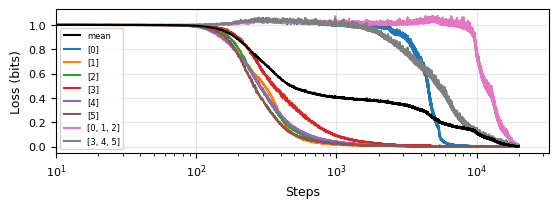

In [6]:
plt.figure(figsize=(5.5, 2))

plt.plot(results['steps'], np.array(results['losses'])/np.log(2), label='mean', color='black', zorder=10)
for i in range(len(codes)):
    plt.plot(results['steps'], np.array(results['subtask_losses'][i])/np.log(2), label=f'{codes[i]}')
plt.xscale('log')
plt.xlabel('Steps', fontsize=9)
plt.ylabel('Loss (bits)', fontsize=9)
plt.xlim(10, None)
plt.grid(True, alpha=0.3)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.legend(prop={'size': 6})
plt.tight_layout(pad=0.4)
plt.savefig('figures/lossesk3m3composite2.pdf')

In [7]:
for i in range(len(codes)):
    print(f"code {codes[i]} loss: {results['subtask_losses'][i][-1]:.10f}")

code [0] loss: 0.0000544321
code [1] loss: 0.0000630611
code [2] loss: 0.0000973892
code [3] loss: 0.0001534399
code [4] loss: 0.0000896910
code [5] loss: 0.0000147117
code [0, 1, 2] loss: 0.0073838029
code [3, 4, 5] loss: 0.0056568668


In [8]:
def compute_ablation_scores(
        model: nn.Sequential, 
        x: torch.Tensor, 
        y: torch.Tensor, 
        loss_fn: Callable) -> Dict[int, List[float]]:
    """
    Returns a list of ablation scores for each hidden neuron in the model.
    """
    scores = defaultdict(list)
    baseline_loss = loss_fn(model(x), y).item()
    for neuroni in range(model[0].out_features):
        mlp_ablation = copy.deepcopy(model)
        mlp_ablation[0].weight.data[neuroni, :] = 0
        mlp_ablation[0].bias.data[neuroni] = 0
        mlp_ablation[2].weight.data[:, neuroni] = 0
        y_pred = mlp_ablation(x)
        loss = loss_fn(y_pred, y)
        scores[0].append(abs(loss.item() - baseline_loss))
    for neuroni in range(model[2].out_features):
        mlp_ablation = copy.deepcopy(model)
        mlp_ablation[2].weight.data[neuroni, :] = 0
        mlp_ablation[2].bias.data[neuroni] = 0
        mlp_ablation[4].weight.data[:, neuroni] = 0
        y_pred = mlp_ablation(x)
        loss = loss_fn(y_pred, y)
        scores[2].append(abs(loss.item() - baseline_loss))
    return scores

In [9]:
ablation_scores = dict()
for i, code in enumerate(codes):
    x, y = get_batch(
        n_tasks,
        args.n,
        Ss,
        [code],
        [train_sizes[i]],
        device=device,
        dtype=dtype,
    )
    ablation_scores[i] = compute_ablation_scores(mlp, x, y, loss_fn)

layer 0 has 64 alive neurons
layer 2 has 64 alive neurons


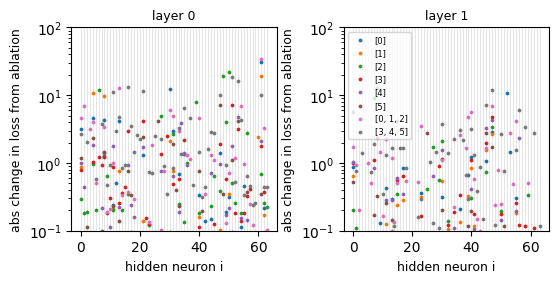

In [10]:

plt.figure(figsize=(5.5, 2.75))

for layeri, layer in enumerate([0, 2]):
    plt.subplot(1, 2, layeri+1)

    # find alive neurons
    alive_neurons = np.ones(len(ablation_scores[0][layer]), dtype=bool)
    for i, code in enumerate(codes):
        alive_neurons = alive_neurons | (np.array(ablation_scores[i][layer]) > 1e-2)
    alive_neurons = np.where(alive_neurons)[0]
    print(f"layer {layer} has {len(alive_neurons)} alive neurons")
    for i, code in enumerate(codes):
        plt.scatter(list(range(len(ablation_scores[i][layer]))), ablation_scores[i][layer], label=f'{code}', s=3)
    for i in range(len(ablation_scores[i][layer])):
        plt.axvline(i, color='black', alpha=0.1, linewidth=0.8)
    plt.xlabel('hidden neuron i', fontsize=9)
    plt.ylabel('abs change in loss from ablation', fontsize=9)
    if layer == 2:
        plt.legend(prop={'size': 6})
    plt.yscale('log')
    plt.ylim(1e-1, 1e2)
    plt.title(f'layer {layeri}', fontsize=9)

plt.tight_layout(pad=0.4)
# plt.savefig('figures/ablationscoresk3m3composite2bothlayers.pdf')

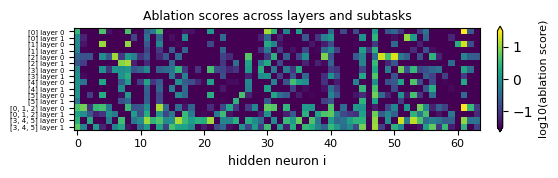

In [11]:
plt.figure(figsize=(5.5, 1.8))

subtaski = 0
layer0_neurons = len(ablation_scores[subtaski][0])
layer2_neurons = len(ablation_scores[subtaski][2])
ablation_img = np.zeros((2*len(codes), max(layer0_neurons, layer2_neurons)))
for i, code in enumerate(codes):
    ablation_img[i*2, :layer0_neurons]   = np.array(ablation_scores[i][0])
    ablation_img[i*2+1, :layer2_neurons] = np.array(ablation_scores[i][2])

im = plt.imshow(
    np.log10(ablation_img + 1e-10),
    vmin=-1.5, vmax=1.5
)

# add shrink to shorten the bar to match the axes height
cbar = plt.colorbar(
    im,
    extend='both',
    fraction=0.046,
    pad=0.04,
    shrink=0.7     # <-- here!
)
cbar.set_label('log10(ablation score)', fontsize=8)

# Add y-tick labels for each task code
yticks = []
yticklabels = []
for i, code in enumerate(codes):
    yticks.extend([i*2, i*2+1])
    yticklabels.extend([f'{code} layer 0', f'{code} layer 1'])
plt.yticks(yticks, yticklabels, fontsize=5)

plt.xlabel('hidden neuron i', fontsize=9)
plt.xticks(fontsize=8)
plt.title('Ablation scores across layers and subtasks', fontsize=9)

plt.tight_layout(pad=0.4)
# plt.savefig('figures/ablationscoresk3m3composite2bothlayersimgshow.pdf')

In [12]:
# let's compute sparsity curves now, with recovery training!

In [13]:
# attribution-based pruning implementation
def prune_by_scores(
        model: nn.Sequential, 
        scores: Dict[int, List[float]], 
        sparsity: float) -> nn.Sequential:
    """
    Returns a copy of the model with the specified sparsity.
    Assumes that `model` alternates between linear layers and non-linearities.
    """
    retained = {i: torch.ones(len(neuron_scores), dtype=torch.bool) 
                for i, neuron_scores in scores.items()}
    n_neurons = sum(s.numel() for s in retained.values())
    layer_neuron_pairs = []
    for i, neuron_scores in scores.items():
        for ni in range(len(neuron_scores)):
            layer_neuron_pairs.append((i, ni, neuron_scores[ni]))
    layer_neuron_pairs.sort(key=lambda x: x[2])
    for layer, ni, _ in islice(layer_neuron_pairs, 0, int(n_neurons * sparsity)):
        retained[layer][ni] = False
    
    pruned = copy.deepcopy(model)
    layeris = sorted(scores.keys())
    for l in range(len(layeris)):
        pruned[layeris[l]].weight.data = model[layeris[l]].weight.data[retained[layeris[l]]]
        pruned[layeris[l]].bias.data = model[layeris[l]].bias.data[retained[layeris[l]]]
        if l == 0:
            pruned[layeris[l]].in_features = model[layeris[l]].in_features
            pruned[layeris[l]].out_features = sum(retained[layeris[l]])
            pruned[layeris[l]].weight.data = model[layeris[l]].weight.data[retained[layeris[l]], :]
            pruned[layeris[l]].bias.data = model[layeris[l]].bias.data[retained[layeris[l]]]
        else:
            pruned[layeris[l]].in_features = sum(retained[layeris[l-1]])
            pruned[layeris[l]].out_features = sum(retained[layeris[l]])
            pruned[layeris[l]].weight.data = model[layeris[l]].weight.data[retained[layeris[l]], :][:, retained[layeris[l-1]]]
            pruned[layeris[l]].bias.data = model[layeris[l]].bias.data[retained[layeris[l]]]
    # last layer doesn't have scores
    pruned[-1].in_features = sum(retained[layeris[l]])
    pruned[-1].out_features = model[-1].out_features
    pruned[-1].weight.data = model[-1].weight.data[:, retained[layeris[l]]]
    pruned[-1].bias.data = model[-1].bias.data
    return pruned

In [14]:
mlp_copy = copy.deepcopy(mlp)

In [15]:
mlp_copy

Sequential(
  (0): Linear(in_features=24, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=2, bias=True)
)

In [17]:
ablation_scores_all = ablation_scores

In [18]:
sparsities = np.arange(0.01, 0.99, 0.01)

losses_ablation = []
accuracies_ablation = []
losses_recovery_ablation = []
accuracies_recovery_ablation = []

losses_ablation_othertask = []
accuracies_ablation_othertask = []
losses_recovery_othertask = []
accuracies_recovery_othertask = []

subtaski = codes.index([0,1,2])
ablation_scores = ablation_scores_all[subtaski]
subtaskj = codes.index([3,4,5])

RECOVERY_STEPS = 1_000
for sparsity in tqdm(sparsities):
    pruned = prune_by_scores(mlp, ablation_scores, sparsity)
    x, y = get_batch(n_tasks, args.n, Ss, [codes[subtaski]], [5000], device=device, dtype=dtype)
    losses_ablation.append(loss_fn(pruned(x), y).item())
    accuracies_ablation.append(pruned(x).argmax(dim=1).eq(y).float().mean().item())
    optimizer = torch.optim.Adam(pruned.parameters(), lr=1e-3)
    for step in range(RECOVERY_STEPS):
        x, y = get_batch(n_tasks, args.n, Ss, [codes[subtaski]], [5000], device=device, dtype=dtype)
        y_pred = pruned(x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses_recovery_ablation.append(loss_fn(pruned(x), y).item())
    accuracies_recovery_ablation.append(pruned(x).argmax(dim=1).eq(y).float().mean().item())

    pruned = prune_by_scores(mlp, ablation_scores, sparsity)
    x, y = get_batch(n_tasks, args.n, Ss, [codes[subtaskj]], [5000], device=device, dtype=dtype)
    losses_ablation_othertask.append(loss_fn(pruned(x), y).item())
    accuracies_ablation_othertask.append(pruned(x).argmax(dim=1).eq(y).float().mean().item())
    optimizer = torch.optim.Adam(pruned.parameters(), lr=1e-3)
    for step in range(RECOVERY_STEPS):
        x, y = get_batch(n_tasks, args.n, Ss, [codes[subtaskj]], [5000], device=device, dtype=dtype)
        y_pred = pruned(x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses_recovery_othertask.append(loss_fn(pruned(x), y).item())
    accuracies_recovery_othertask.append(pruned(x).argmax(dim=1).eq(y).float().mean().item())

100%|██████████| 98/98 [03:15<00:00,  2.00s/it]


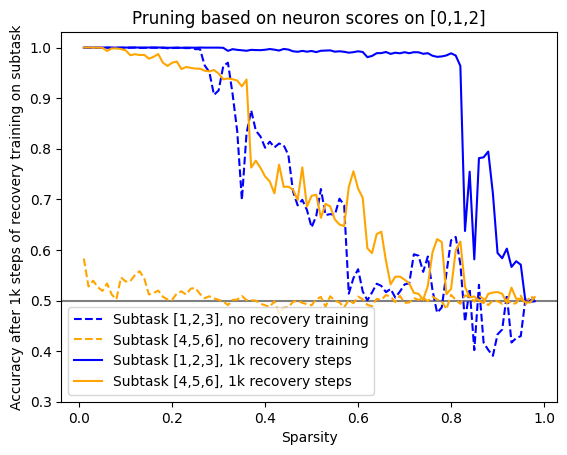

In [28]:
plt.plot(sparsities, accuracies_ablation, label='Subtask [1,2,3], no recovery training', color='blue', linestyle='--')
plt.plot(sparsities, accuracies_ablation_othertask, label='Subtask [4,5,6], no recovery training', color='orange', linestyle='--')
plt.plot(sparsities, accuracies_recovery_ablation, label='Subtask [1,2,3], 1k recovery steps', color='blue')
plt.plot(sparsities, accuracies_recovery_othertask, label='Subtask [4,5,6], 1k recovery steps', color='orange')
plt.axhline(0.5, color='black', alpha=0.5, zorder=-5)
plt.xlabel('Sparsity')
plt.ylabel('Accuracy after 1k steps of recovery training on subtask')
plt.title("Pruning based on neuron scores on [0,1,2]")
plt.legend(loc='lower left')
plt.ylim(0.3, None)
plt.show()


In [110]:
# ideas: 
# - emphasize starkness of unlearning results. unlearning is stronger after l1 regularization
# - train a smaller network and look at those results.

In [39]:
args = argparse.Namespace()
args.n = 18
args.width = 512
args.depth = 3
args.activation = "ReLU"
args.lr = 1e-3
args.layernorm = False
args.samples_per_task = 2000
args.steps = 40_000
args.verbose = True
args.seed = 0
args.device = "cuda" if torch.cuda.is_available() else "cpu"
args.dtype = "float32"

In [40]:
Ss = [
    [0, 1, 2,],
    [3, 4, 5],
    [6, 7, 8],
    [9, 10, 11],
    [12, 13, 14],
    [15, 16, 17],
]
n_tasks = len(Ss)
codes = [[i] for i in range(n_tasks)] + [[0,1,2]] + [[3,4,5]]
train_sizes = [args.samples_per_task] * len(codes)

In [41]:
def train():

    torch.manual_seed(args.seed)
    torch.cuda.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)
    torch.backends.cudnn.deterministic = True

    if args.dtype == "float32":
        dtype = torch.float32
    else:
        dtype = torch.float64

    device = torch.device(args.device)

    if args.activation == "ReLU":
        activation_fn = nn.ReLU
    elif args.activation == "Tanh":
        activation_fn = nn.Tanh
    else:
        activation_fn = nn.Sigmoid

    layers = []
    for i in range(args.depth):
        if i == 0:
            if args.layernorm:
                layers.append(nn.LayerNorm(n_tasks + args.n))
            layers.append(nn.Linear(n_tasks + args.n, args.width))
            layers.append(activation_fn())
        elif i == args.depth - 1:
            if args.layernorm:
                layers.append(nn.LayerNorm(args.width))
            layers.append(nn.Linear(args.width, 2))
        else:
            if args.layernorm:
                layers.append(nn.LayerNorm(args.width))
            layers.append(nn.Linear(args.width, args.width))
            layers.append(activation_fn())

    mlp = nn.Sequential(*layers).to(dtype).to(device)

    ps = sum(p.numel() for p in mlp.parameters())
    # print("Number of parameters:", ps)

    optimizer = torch.optim.Adam(mlp.parameters(), lr=args.lr, eps=1e-5)
    loss_fn = nn.CrossEntropyLoss()

    steps = []
    samples = []
    losses = []
    subtask_losses = defaultdict(list)

    for step in tqdm(range(args.steps), disable=not args.verbose):
        with torch.no_grad():
            for i, code in enumerate(codes):
                x, y = get_batch(
                    n_tasks,
                    args.n,
                    Ss,
                    [code],
                    [train_sizes[i]],
                    device=device,
                    dtype=dtype,
                )
                y_pred = mlp(x)
                subtask_losses[i].append(loss_fn(y_pred, y).item())

        x, y = get_batch(
            n_tasks, args.n, Ss, codes, train_sizes, device=device, dtype=dtype
        )
        y_pred = mlp(x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        steps.append(step)
        losses.append(loss.item())
        samples.append(x.shape[0])

    results = {
        "steps": steps,
        "losses": losses,
        "subtask_losses": subtask_losses,
        "Ss": Ss,
        "codes": codes,
        "n_parameters": ps,
        "samples": samples,
    }

    return mlp, results, device, dtype, loss_fn

mlp, results, device, dtype, loss_fn = train()

100%|██████████| 40000/40000 [04:55<00:00, 135.44it/s]


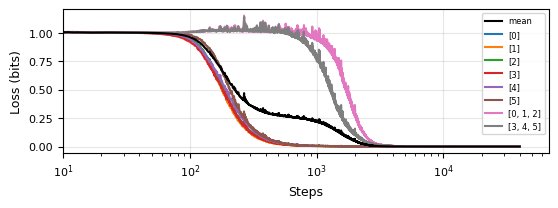

In [42]:
plt.figure(figsize=(5.5, 2))

plt.plot(results['steps'], np.array(results['losses'])/np.log(2), label='mean', color='black', zorder=10)
for i in range(len(codes)):
    plt.plot(results['steps'], np.array(results['subtask_losses'][i])/np.log(2), label=f'{codes[i]}')
plt.xscale('log')
plt.xlabel('Steps', fontsize=9)
plt.ylabel('Loss (bits)', fontsize=9)
plt.xlim(10, None)
plt.grid(True, alpha=0.3)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.legend(prop={'size': 6})
plt.tight_layout(pad=0.4)
# plt.savefig('figures/lossesk3m3composite2.pdf')

In [43]:
for i in range(len(codes)):
    print(f"code {codes[i]} loss: {results['subtask_losses'][i][-1]:.10f}")

code [0] loss: 0.0000000768
code [1] loss: 0.0000000412
code [2] loss: 0.0000000984
code [3] loss: 0.0000001038
code [4] loss: 0.0000000896
code [5] loss: 0.0000000833
code [0, 1, 2] loss: 0.0000011255
code [3, 4, 5] loss: 0.0000008965


In [44]:
def compute_ablation_scores(
        model: nn.Sequential, 
        x: torch.Tensor, 
        y: torch.Tensor, 
        loss_fn: Callable) -> Dict[int, List[float]]:
    """
    Returns a list of ablation scores for each hidden neuron in the model.
    """
    scores = defaultdict(list)
    baseline_loss = loss_fn(model(x), y).item()
    for neuroni in range(model[0].out_features):
        mlp_ablation = copy.deepcopy(model)
        mlp_ablation[0].weight.data[neuroni, :] = 0
        mlp_ablation[0].bias.data[neuroni] = 0
        mlp_ablation[2].weight.data[:, neuroni] = 0
        y_pred = mlp_ablation(x)
        loss = loss_fn(y_pred, y)
        scores[0].append(abs(loss.item() - baseline_loss))
    for neuroni in range(model[2].out_features):
        mlp_ablation = copy.deepcopy(model)
        mlp_ablation[2].weight.data[neuroni, :] = 0
        mlp_ablation[2].bias.data[neuroni] = 0
        mlp_ablation[4].weight.data[:, neuroni] = 0
        y_pred = mlp_ablation(x)
        loss = loss_fn(y_pred, y)
        scores[2].append(abs(loss.item() - baseline_loss))
    return scores

In [45]:
ablation_scores = dict()
for i, code in enumerate(codes):
    x, y = get_batch(
        n_tasks,
        args.n,
        Ss,
        [code],
        [train_sizes[i]],
        device=device,
        dtype=dtype,
    )
    ablation_scores[i] = compute_ablation_scores(mlp, x, y, loss_fn)

layer 0 has 512 alive neurons
layer 2 has 512 alive neurons


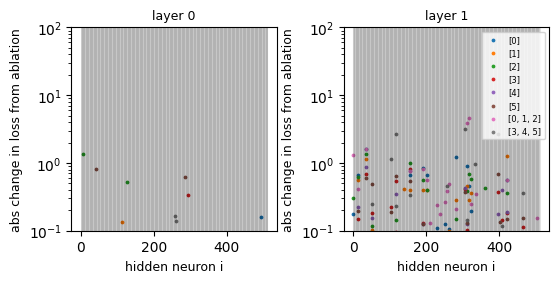

In [46]:

plt.figure(figsize=(5.5, 2.75))

for layeri, layer in enumerate([0, 2]):
    plt.subplot(1, 2, layeri+1)

    # find alive neurons
    alive_neurons = np.ones(len(ablation_scores[0][layer]), dtype=bool)
    for i, code in enumerate(codes):
        alive_neurons = alive_neurons | (np.array(ablation_scores[i][layer]) > 1e-2)
    alive_neurons = np.where(alive_neurons)[0]
    print(f"layer {layer} has {len(alive_neurons)} alive neurons")
    for i, code in enumerate(codes):
        plt.scatter(list(range(len(ablation_scores[i][layer]))), ablation_scores[i][layer], label=f'{code}', s=3)
    for i in range(len(ablation_scores[i][layer])):
        plt.axvline(i, color='black', alpha=0.1, linewidth=0.8)
    plt.xlabel('hidden neuron i', fontsize=9)
    plt.ylabel('abs change in loss from ablation', fontsize=9)
    if layer == 2:
        plt.legend(prop={'size': 6})
    plt.yscale('log')
    plt.ylim(1e-1, 1e2)
    plt.title(f'layer {layeri}', fontsize=9)

plt.tight_layout(pad=0.4)
# plt.savefig('figures/ablationscoresk3m3composite2bothlayers.pdf')

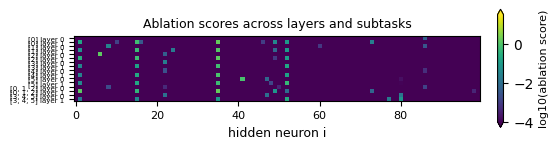

In [51]:
plt.figure(figsize=(5.5, 1.8))

subtaski = 0
layer0_neurons = len(ablation_scores[subtaski][0])
layer2_neurons = len(ablation_scores[subtaski][2])
ablation_img = np.zeros((2*len(codes), max(layer0_neurons, layer2_neurons)))
for i, code in enumerate(codes):
    ablation_img[i*2, :layer0_neurons]   = np.array(ablation_scores[i][0])
    ablation_img[i*2+1, :layer2_neurons] = np.array(ablation_scores[i][2])

im = plt.imshow(
    np.log10(ablation_img[:, :100] + 1e-10),
    vmin=-4, vmax=1.5
)

# add shrink to shorten the bar to match the axes height
cbar = plt.colorbar(
    im,
    extend='both',
    fraction=0.046,
    pad=0.04,
    shrink=0.7     # <-- here!
)
cbar.set_label('log10(ablation score)', fontsize=8)

# Add y-tick labels for each task code
yticks = []
yticklabels = []
for i, code in enumerate(codes):
    yticks.extend([i*2, i*2+1])
    yticklabels.extend([f'{code} layer 0', f'{code} layer 1'])
plt.yticks(yticks, yticklabels, fontsize=5)

plt.xlabel('hidden neuron i', fontsize=9)
plt.xticks(fontsize=8)
plt.title('Ablation scores across layers and subtasks', fontsize=9)

plt.tight_layout(pad=0.4)
# plt.savefig('figures/ablationscoresk3m3composite2bothlayersimgshow.pdf')

In [ ]:
# let's compute sparsity curves now, with recovery training!

In [52]:
mlp_copy = copy.deepcopy(mlp)

In [53]:
mlp_copy

Sequential(
  (0): Linear(in_features=24, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=2, bias=True)
)

In [54]:
ablation_scores_all = ablation_scores

In [55]:
sparsities = np.arange(0.01, 0.99, 0.01)

losses_ablation = []
accuracies_ablation = []
losses_recovery_ablation = []
accuracies_recovery_ablation = []

losses_ablation_othertask = []
accuracies_ablation_othertask = []
losses_recovery_othertask = []
accuracies_recovery_othertask = []

subtaski = codes.index([0,1,2])
ablation_scores = ablation_scores_all[subtaski]
subtaskj = codes.index([3,4,5])

RECOVERY_STEPS = 1_000
for sparsity in tqdm(sparsities):
    pruned = prune_by_scores(mlp, ablation_scores, sparsity)
    x, y = get_batch(n_tasks, args.n, Ss, [codes[subtaski]], [5000], device=device, dtype=dtype)
    losses_ablation.append(loss_fn(pruned(x), y).item())
    accuracies_ablation.append(pruned(x).argmax(dim=1).eq(y).float().mean().item())
    optimizer = torch.optim.Adam(pruned.parameters(), lr=1e-3)
    for step in range(RECOVERY_STEPS):
        x, y = get_batch(n_tasks, args.n, Ss, [codes[subtaski]], [5000], device=device, dtype=dtype)
        y_pred = pruned(x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses_recovery_ablation.append(loss_fn(pruned(x), y).item())
    accuracies_recovery_ablation.append(pruned(x).argmax(dim=1).eq(y).float().mean().item())

    pruned = prune_by_scores(mlp, ablation_scores, sparsity)
    x, y = get_batch(n_tasks, args.n, Ss, [codes[subtaskj]], [5000], device=device, dtype=dtype)
    losses_ablation_othertask.append(loss_fn(pruned(x), y).item())
    accuracies_ablation_othertask.append(pruned(x).argmax(dim=1).eq(y).float().mean().item())
    optimizer = torch.optim.Adam(pruned.parameters(), lr=1e-3)
    for step in range(RECOVERY_STEPS):
        x, y = get_batch(n_tasks, args.n, Ss, [codes[subtaskj]], [5000], device=device, dtype=dtype)
        y_pred = pruned(x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses_recovery_othertask.append(loss_fn(pruned(x), y).item())
    accuracies_recovery_othertask.append(pruned(x).argmax(dim=1).eq(y).float().mean().item())

100%|██████████| 98/98 [03:28<00:00,  2.13s/it]


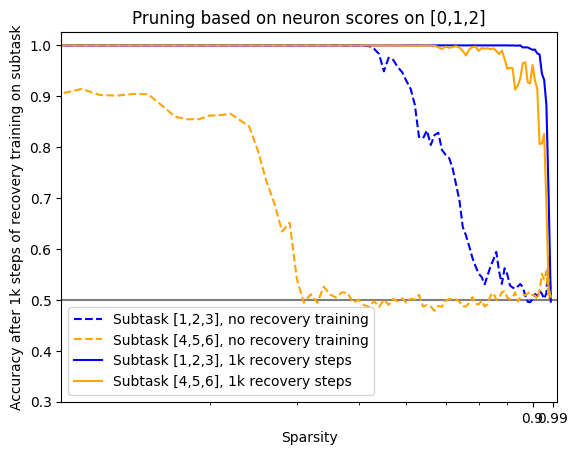

In [59]:
plt.plot(sparsities, accuracies_ablation, label='Subtask [1,2,3], no recovery training', color='blue', linestyle='--')
plt.plot(sparsities, accuracies_ablation_othertask, label='Subtask [4,5,6], no recovery training', color='orange', linestyle='--')
plt.plot(sparsities, accuracies_recovery_ablation, label='Subtask [1,2,3], 1k recovery steps', color='blue')
plt.plot(sparsities, accuracies_recovery_othertask, label='Subtask [4,5,6], 1k recovery steps', color='orange')
plt.axhline(0.5, color='black', alpha=0.5, zorder=-5)
plt.xscale('log')
plt.xticks([0.9, 0.99], ['0.9', '0.99'])
plt.xlim(0.1, 1.01)  # Set limits to focus on the 0.9-1.0 range
plt.xlabel('Sparsity')
plt.ylabel('Accuracy after 1k steps of recovery training on subtask')
plt.title("Pruning based on neuron scores on [0,1,2]")
plt.legend(loc='lower left')
plt.ylim(0.3, None)
plt.show()


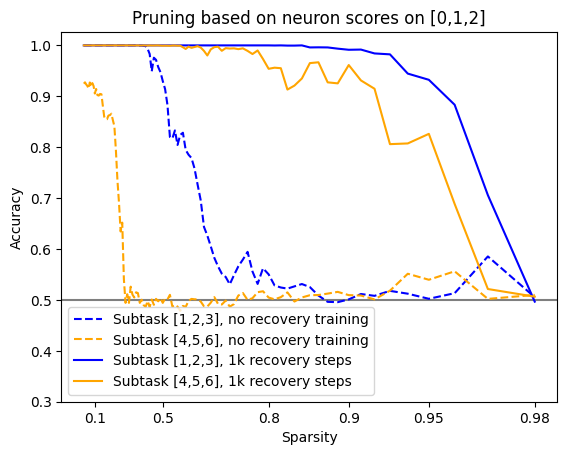

In [66]:
import numpy as np
import matplotlib.pyplot as plt

# your data
x = np.array(sparsities)
y1 = accuracies_ablation
y2 = accuracies_ablation_othertask
y3 = accuracies_recovery_ablation
y4 = accuracies_recovery_othertask

# non‐linear transform
u = -np.log10(1 - x)

fig, ax = plt.subplots()

ax.plot(u, y1, label='Subtask [0,1,2], no recovery training',
        color='blue', linestyle='--')
ax.plot(u, y2, label='Subtask [3,4,5], no recovery training',
        color='orange', linestyle='--')
ax.plot(u, y3, label='Subtask [0,1,2], 1k recovery steps',
        color='blue')
ax.plot(u, y4, label='Subtask [3,4,5], 1k recovery steps',
        color='orange')
ax.axhline(0.5, color='black', alpha=0.5, zorder=-5)

# choose the x‐ticks at your desired sparsities
desired = [0.1, 0.5, 0.8, 0.9, 0.95, 0.98]
u_ticks = -np.log10(1 - np.array(desired))
ax.set_xticks(u_ticks)
ax.set_xticklabels([str(d) for d in desired])

ax.set_xlabel('Sparsity')
ax.set_ylabel('Accuracy')
ax.set_title("Pruning based on neuron scores on [0,1,2]")
ax.legend(loc='lower left')
ax.set_ylim(0.3, None)

plt.show()


In [67]:
import pickle

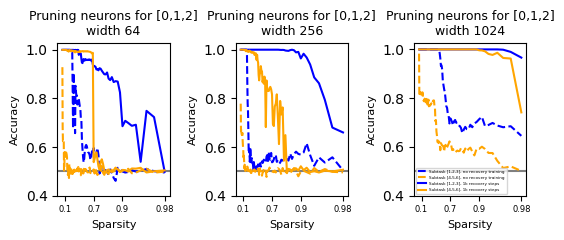

In [93]:
plt.figure(figsize=(5.5, 2.5))

widths = [64, 256, 1024]
for ploti, width in enumerate(widths):
    ax = plt.subplot(1, len(widths), ploti+1)

    # load up data
    with open(f'../experiments/compositions3/results/width{width}/ablation_results.pkl', 'rb') as f:
        ablation_results = pickle.load(f)
    with open(f"../experiments/compositions3/results/width{width}/sparsities.pkl", 'rb') as f:
        sparsities = pickle.load(f)
    x = np.array(sparsities)
    y1 = ablation_results['accuracies_ablation']
    y2 = ablation_results['accuracies_ablation_othertask']
    y3 = ablation_results['accuracies_recovery_ablation']
    y4 = ablation_results['accuracies_recovery_othertask']
    u = -np.log10(1 - x)
    ax.plot(u, y1, label='Subtask [1,2,3], no recovery training',
            color='blue', linestyle='--')
    ax.plot(u, y2, label='Subtask [4,5,6], no recovery training',
            color='orange', linestyle='--')
    ax.plot(u, y3, label='Subtask [1,2,3], 1k recovery steps',
            color='blue')
    ax.plot(u, y4, label='Subtask [4,5,6], 1k recovery steps',
            color='orange')
    ax.axhline(0.5, color='black', alpha=0.5, zorder=-5)
    desired = [0.1, 0.7, 0.9, 0.98]
    u_ticks = -np.log10(1 - np.array(desired))
    ax.set_xticks(u_ticks)
    ax.set_xticklabels([str(d) for d in desired], fontsize=6)

    ax.set_xlabel('Sparsity', fontsize=8)
    ax.set_ylabel('Accuracy', fontsize=8)
    ax.set_title(f"Pruning neurons for [0,1,2]\nwidth {width}", fontsize=9)
    if ploti == 2:
        ax.legend(loc='lower left', prop={'size': 3})
    ax.set_ylim(0.4, None)

plt.tight_layout()


<Figure size 550x250 with 0 Axes>

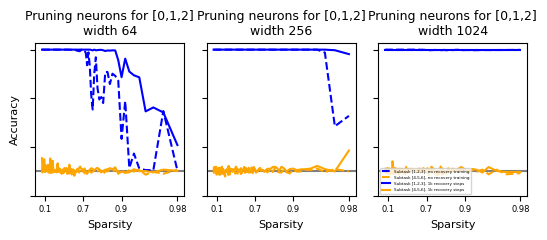

In [ ]:
plt.figure(figsize=(5.5, 2.5))

widths = [64, 256, 1024]
for ploti, width in enumerate(widths):
    ax = plt.subplot(1, len(widths), ploti+1)

    # load up data
    with open(f'../experiments/compositions3/results/width{width}/ablation_results_regularization.pkl', 'rb') as f:
        ablation_results = pickle.load(f)
    with open(f"../experiments/compositions3/results/width{width}/sparsities.pkl", 'rb') as f:
        sparsities = pickle.load(f)
    x = np.array(sparsities)
    y1 = ablation_results['accuracies_ablation']
    y2 = ablation_results['accuracies_ablation_othertask']
    y3 = ablation_results['accuracies_recovery_ablation']
    y4 = ablation_results['accuracies_recovery_othertask']
    u = -np.log10(1 - x)
    ax.plot(u, y1, label='Subtask [1,2,3], no recovery training',
            color='blue', linestyle='--')
    ax.plot(u, y2, label='Subtask [4,5,6], no recovery training',
            color='orange', linestyle='--')
    ax.plot(u, y3, label='Subtask [1,2,3], 1k recovery steps',
            color='blue')
    ax.plot(u, y4, label='Subtask [4,5,6], 1k recovery steps',
            color='orange')
    ax.axhline(0.5, color='black', alpha=0.5, zorder=-5)
    desired = [0.1, 0.7, 0.9, 0.98]
    u_ticks = -np.log10(1 - np.array(desired))
    ax.set_xticks(u_ticks)
    ax.set_xticklabels([str(d) for d in desired], fontsize=6)

    ax.set_xlabel('Sparsity', fontsize=8)
    ax.set_ylabel('Accuracy', fontsize=8)
    ax.set_title(f"Pruning neurons for [0,1,2]\nwidth {width}", fontsize=9)
    if ploti == 2:
        ax.legend(loc='lower left', prop={'size': 3})
    ax.set_ylim(0.4, None)

plt.tight_layout()

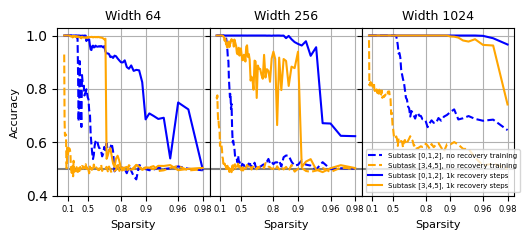

In [26]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

widths = [64, 256, 1024]

fig, axes = plt.subplots(
    nrows=1, ncols=len(widths),
    figsize=(5.5, 2.5),
    sharey=True,
    gridspec_kw={'wspace': 0}
)

for ax, width, idx in zip(axes, widths, range(len(widths))):
    # load up data
    with open(f'../experiments/compositions3/results/width{width}/ablation_results.pkl', 'rb') as f:
        ablation_results = pickle.load(f)
    with open(f"../experiments/compositions3/results/width{width}/sparsities.pkl", 'rb') as f:
        sparsities = pickle.load(f)

    x = np.array(sparsities)
    y1 = ablation_results['accuracies_ablation']
    y2 = ablation_results['accuracies_ablation_othertask']
    y3 = ablation_results['accuracies_recovery_ablation']
    y4 = ablation_results['accuracies_recovery_othertask']
    u = -np.log10(1 - x)

    # plot curves with original colors
    ax.plot(u, y1,
            label='Subtask [0,1,2], no recovery training',
            color='blue', linestyle='--')
    ax.plot(u, y2,
            label='Subtask [3,4,5], no recovery training',
            color='orange', linestyle='--')
    ax.plot(u, y3,
            label='Subtask [0,1,2], 1k recovery steps',
            color='blue')
    ax.plot(u, y4,
            label='Subtask [3,4,5], 1k recovery steps',
            color='orange')

    ax.axhline(0.5, color='black', alpha=0.5, zorder=-5)

    # xticks at desired sparsities
    desired = [0.1, 0.5, 0.8, 0.9, 0.96, 0.98]
    u_ticks = -np.log10(1 - np.array(desired))
    ax.set_xticks(u_ticks)
    ax.set_xticklabels([str(d) for d in desired], fontsize=6)

    # x‐label on every subplot
    ax.set_xlabel('Sparsity', fontsize=8)
    # y‐label only on the first subplot
    if idx == 0:
        ax.set_ylabel('Accuracy', fontsize=8)
    else:
        ax.tick_params(labelleft=False)

    ax.set_title(f"Width {width}", fontsize=9)

    if idx == 2:
        ax.legend(loc='lower left', prop={'size': 5})

    ax.set_ylim(0.4, None)
    # add grid
    ax.grid(True)

plt.tight_layout()
plt.savefig("figures/sparsityvsaccuracycmsppretrained.pdf")


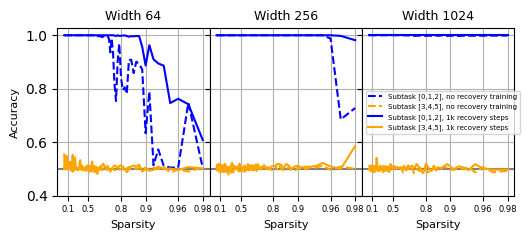

In [27]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

widths = [64, 256, 1024]

fig, axes = plt.subplots(
    nrows=1, ncols=len(widths),
    figsize=(5.5, 2.5),
    sharey=True,
    gridspec_kw={'wspace': 0}
)

for ax, width, idx in zip(axes, widths, range(len(widths))):
    # load up data
    with open(f'../experiments/compositions3/results/width{width}/ablation_results_regularization.pkl', 'rb') as f:
        ablation_results = pickle.load(f)
    with open(f"../experiments/compositions3/results/width{width}/sparsities.pkl", 'rb') as f:
        sparsities = pickle.load(f)

    x = np.array(sparsities)
    y1 = ablation_results['accuracies_ablation']
    y2 = ablation_results['accuracies_ablation_othertask']
    y3 = ablation_results['accuracies_recovery_ablation']
    y4 = ablation_results['accuracies_recovery_othertask']
    u = -np.log10(1 - x)

    # plot curves with original colors
    ax.plot(u, y1,
            label='Subtask [0,1,2], no recovery training',
            color='blue', linestyle='--')
    ax.plot(u, y2,
            label='Subtask [3,4,5], no recovery training',
            color='orange', linestyle='--')
    ax.plot(u, y3,
            label='Subtask [0,1,2], 1k recovery steps',
            color='blue')
    ax.plot(u, y4,
            label='Subtask [3,4,5], 1k recovery steps',
            color='orange')

    ax.axhline(0.5, color='black', alpha=0.5, zorder=-5)

    # xticks at desired sparsities
    desired = [0.1, 0.5, 0.8, 0.9, 0.96, 0.98]
    u_ticks = -np.log10(1 - np.array(desired))
    ax.set_xticks(u_ticks)
    ax.set_xticklabels([str(d) for d in desired], fontsize=6)

    # x‐label on every subplot
    ax.set_xlabel('Sparsity', fontsize=8)
    # y‐label only on the first subplot
    if idx == 0:
        ax.set_ylabel('Accuracy', fontsize=8)
    else:
        ax.tick_params(labelleft=False)

    ax.set_title(f"Width {width}", fontsize=9)

    if idx == 2:
        ax.legend(loc='center left', prop={'size': 5})

    ax.set_ylim(0.4, None)
    # add grid
    ax.grid(True)

plt.tight_layout()
plt.savefig("figures/sparsityvsaccuracycmspregularized.pdf")

In [28]:
def visualize_mlp(model, weight_threshold=0.3, color_range=[-1, 1], s=10, ax=None):
    
    assert isinstance(model, nn.Sequential), "Model must be nn.Sequential"
    layers = [module for module in model if isinstance(module, nn.Linear)]
    
    # Use provided axis or create a new one
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
    
    # Determine maximum neuron count in any layer for plotting bounds
    max_width = max(
        max(layer.in_features, layer.out_features) for layer in layers
    )
    ax.set_xlim(-max_width * 0.05, max_width * 1.05)
    ax.set_ylim(-0.2, len(layers) + 0.2)
    
    # Compute positions for neurons in each layer
    positions = []
    for i, layer in enumerate(layers):
        pos = np.linspace(0, max_width - 1, layer.in_features)
        positions.append(pos)
    # Positions for neurons in the final layer
    positions.append(np.linspace(0, max_width - 1, layers[-1].out_features))
    
    # Plot the neurons as black dots
    for i, layer in enumerate(layers):
        ax.scatter(positions[i], [i] * layer.in_features, s=s, c='black', zorder=10)
    ax.scatter(positions[-1], [len(layers)] * layers[-1].out_features, s=s, c='black', zorder=10)
    
    # Plot the connections with constant line thickness
    for i, layer in enumerate(layers):
        weights = layer.weight.detach().cpu().numpy()
        for j in range(layer.in_features):
            for k in range(layer.out_features):
                weight = weights[k, j]
                if abs(weight) > weight_threshold:
                    color = plt.cm.bwr((weight - color_range[0]) / (color_range[1] - color_range[0]))
                    ax.plot(
                        [positions[i][j], positions[i+1][k]],
                        [i, i+1],
                        c=color,
                        linewidth=2,  # constant thickness
                        alpha=0.7
                    )

In [53]:
# let's load up the width 64 mlp
width = 64
depth = 3
n = 18
n_tasks = 6
activation = "ReLU"
layernorm = False

dtype = torch.float32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if activation == "ReLU":
    activation_fn = nn.ReLU
elif activation == "Tanh":
    activation_fn = nn.Tanh
else:
    activation_fn = nn.Sigmoid

layers = []
for i in range(depth):
    if i == 0:
        if layernorm:
            layers.append(nn.LayerNorm(n_tasks + n))
        layers.append(nn.Linear(n_tasks + n, width))
        layers.append(activation_fn())
    elif i == depth - 1:
        if layernorm:
            layers.append(nn.LayerNorm(width))
        layers.append(nn.Linear(width, 2))
    else:
        if layernorm:
            layers.append(nn.LayerNorm(width))
        layers.append(nn.Linear(width, width))
        layers.append(activation_fn())

mlp = nn.Sequential(*layers).to(dtype).to(device)
mlp.load_state_dict(torch.load(f"../experiments/compositions3/results/width{width}/model.pt"))


/tmp/ipykernel_2453940/4183528714.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp.load_state_dict(torch.load(f"../experiments/compositions3/results/width{width}/mod

<All keys matched successfully>

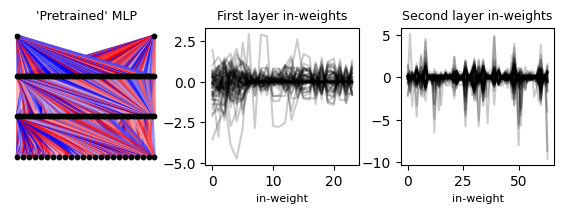

In [54]:
plt.figure(figsize=(5.5, 2))

ax = plt.subplot(1, 3, 1)
visualize_mlp(mlp, ax=ax)
plt.axis('off')
plt.title("'Pretrained' MLP", fontsize=9)

plt.subplot(1, 3, 2)
for neuroni in range(width):

    plt.plot(mlp[0].weight[neuroni].detach().cpu().numpy(), color='black', alpha=0.2)
plt.xlabel('in-weight', fontsize=8)
# plt.ylabel(r'$w_{ij}$')
plt.title('First layer in-weights', fontsize=9)

plt.subplot(1, 3, 3)
for neuroni in range(width):
    plt.plot(mlp[2].weight[neuroni].detach().cpu().numpy(), color='black', alpha=0.2)
plt.xlabel('in-weight', fontsize=8)
# plt.ylabel(r'$w_{ij}$', fontsize=8)
plt.title('Second layer in-weights', fontsize=9)

plt.tight_layout(pad=0.2)
plt.savefig("figures/cmsppretrainedmlpweights.png", dpi=250)

In [55]:
# let's load up the width 64 mlp
width = 64
depth = 3
n = 18
n_tasks = 6
activation = "ReLU"
layernorm = False

dtype = torch.float32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if activation == "ReLU":
    activation_fn = nn.ReLU
elif activation == "Tanh":
    activation_fn = nn.Tanh
else:
    activation_fn = nn.Sigmoid

layers = []
for i in range(depth):
    if i == 0:
        if layernorm:
            layers.append(nn.LayerNorm(n_tasks + n))
        layers.append(nn.Linear(n_tasks + n, width))
        layers.append(activation_fn())
    elif i == depth - 1:
        if layernorm:
            layers.append(nn.LayerNorm(width))
        layers.append(nn.Linear(width, 2))
    else:
        if layernorm:
            layers.append(nn.LayerNorm(width))
        layers.append(nn.Linear(width, width))
        layers.append(activation_fn())

mlp = nn.Sequential(*layers).to(dtype).to(device)
mlp.load_state_dict(torch.load(f"../experiments/compositions3/results/width{width}/model_regularized.pt"))


/tmp/ipykernel_2453940/3861373053.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp.load_state_dict(torch.load(f"../experiments/compositions3/results/width{width}/mod

<All keys matched successfully>

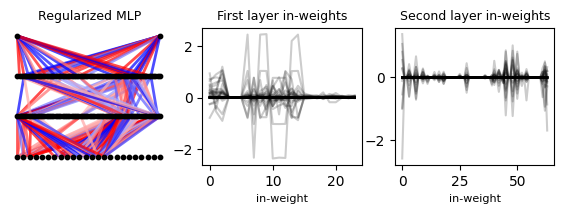

In [56]:
plt.figure(figsize=(5.5, 2))

ax = plt.subplot(1, 3, 1)
visualize_mlp(mlp, ax=ax)
plt.axis('off')
plt.title("Regularized MLP", fontsize=9)

plt.subplot(1, 3, 2)
for neuroni in range(width):

    plt.plot(mlp[0].weight[neuroni].detach().cpu().numpy(), color='black', alpha=0.2)
plt.xlabel('in-weight', fontsize=8)
# plt.ylabel(r'$w_{ij}$')
plt.title('First layer in-weights', fontsize=9)

plt.subplot(1, 3, 3)
for neuroni in range(width):
    plt.plot(mlp[2].weight[neuroni].detach().cpu().numpy(), color='black', alpha=0.2)
plt.xlabel('in-weight', fontsize=8)
# plt.ylabel(r'$w_{ij}$', fontsize=8)
plt.title('Second layer in-weights', fontsize=9)

plt.tight_layout(pad=0.2)
plt.savefig("figures/cmsppregularizedmlpweights.png", dpi=250)

Let's return to the two-task case and see if we can get the same results (I messed up my plotting before)

In [ ]:
args = argparse.Namespace()
args.n = 16
args.width = 32
args.depth = 3
args.activation = "ReLU"
args.lr = 1e-3
args.layernorm = False
args.samples_per_task = 2000
args.steps = 10_000
args.verbose = True
args.seed = 0
args.device = "cuda" if torch.cuda.is_available() else "cpu"
args.dtype = "float32"

In [63]:
Ss = [
    [0, 1, 2, 3],
    [4, 5, 6, 7],
]
n_tasks = len(Ss)
codes = [[i] for i in range(n_tasks)]
train_sizes = [args.samples_per_task] * len(codes)

In [64]:
codes

[[0], [1]]

In [65]:
def train():

    torch.manual_seed(args.seed)
    torch.cuda.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)
    torch.backends.cudnn.deterministic = True

    if args.dtype == "float32":
        dtype = torch.float32
    else:
        dtype = torch.float64

    device = torch.device(args.device)

    if args.activation == "ReLU":
        activation_fn = nn.ReLU
    elif args.activation == "Tanh":
        activation_fn = nn.Tanh
    else:
        activation_fn = nn.Sigmoid

    layers = []
    for i in range(args.depth):
        if i == 0:
            if args.layernorm:
                layers.append(nn.LayerNorm(n_tasks + args.n))
            layers.append(nn.Linear(n_tasks + args.n, args.width))
            layers.append(activation_fn())
        elif i == args.depth - 1:
            if args.layernorm:
                layers.append(nn.LayerNorm(args.width))
            layers.append(nn.Linear(args.width, 2))
        else:
            if args.layernorm:
                layers.append(nn.LayerNorm(args.width))
            layers.append(nn.Linear(args.width, args.width))
            layers.append(activation_fn())

    mlp = nn.Sequential(*layers).to(dtype).to(device)

    ps = sum(p.numel() for p in mlp.parameters())
    # print("Number of parameters:", ps)

    optimizer = torch.optim.Adam(mlp.parameters(), lr=args.lr, eps=1e-5)
    loss_fn = nn.CrossEntropyLoss()

    steps = []
    samples = []
    losses = []
    subtask_losses = defaultdict(list)

    for step in tqdm(range(args.steps), disable=not args.verbose):
        with torch.no_grad():
            for i, code in enumerate(codes):
                x, y = get_batch(
                    n_tasks,
                    args.n,
                    Ss,
                    [code],
                    [train_sizes[i]],
                    device=device,
                    dtype=dtype,
                )
                y_pred = mlp(x)
                subtask_losses[i].append(loss_fn(y_pred, y).item())

        x, y = get_batch(
            n_tasks, args.n, Ss, codes, train_sizes, device=device, dtype=dtype
        )
        y_pred = mlp(x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        steps.append(step)
        losses.append(loss.item())
        samples.append(x.shape[0])

    results = {
        "steps": steps,
        "losses": losses,
        "subtask_losses": subtask_losses,
        "Ss": Ss,
        "codes": codes,
        "n_parameters": ps,
        "samples": samples,
    }

    return mlp, results, device, dtype, loss_fn

mlp, results, device, dtype, loss_fn = train()

100%|██████████| 10000/10000 [00:23<00:00, 428.21it/s]


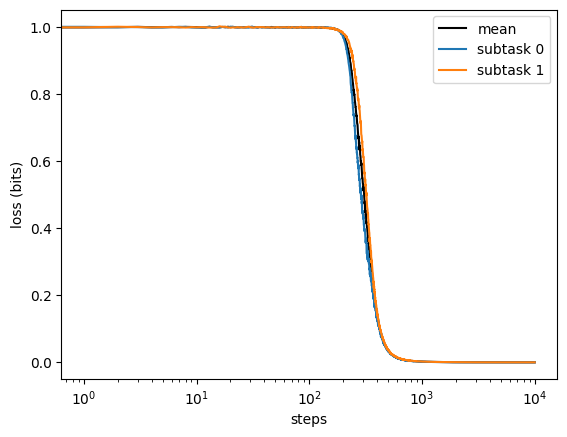

In [66]:
plt.plot(results['steps'], np.array(results['losses'])/np.log(2), label='mean', color='black')
for i in range(len(codes)):
    plt.plot(results['steps'], np.array(results['subtask_losses'][i])/np.log(2), label=f'subtask {i}')
plt.xscale('log')
plt.xlabel('steps')
plt.ylabel('loss (bits)')
plt.legend()

In [67]:
ablation_scores = dict()
for i, code in enumerate(codes):
    x, y = get_batch(
        n_tasks,
        args.n,
        Ss,
        [code],
        [train_sizes[i]],
        device=device,
        dtype=dtype,
    )
    ablation_scores[i] = compute_ablation_scores(mlp, x, y, loss_fn)

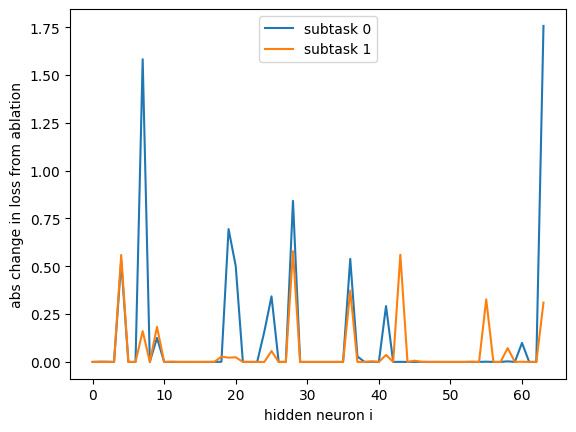

In [68]:
for i, code in enumerate(codes):
    plt.plot(ablation_scores[i], label=f'subtask {i}')
plt.xlabel('hidden neuron i')
plt.ylabel('abs change in loss from ablation')
plt.legend()

In [101]:
alive_neurons = ((np.array(ablation_scores[0]) > 1e-4) | (np.array(ablation_scores[1]) > 1e-4)).nonzero()[0]
print(f"There are {len(alive_neurons)} alive neurons: {alive_neurons}")
scores = []
for neuroni in alive_neurons:
    scores.append(ablation_scores[0][neuroni] / ablation_scores[1][neuroni])

There are 29 alive neurons: [ 1  2  4  7  9 11 16 18 19 20 21 24 25 28 36 37 39 40 41 43 45 46 48 53
 55 58 59 60 63]


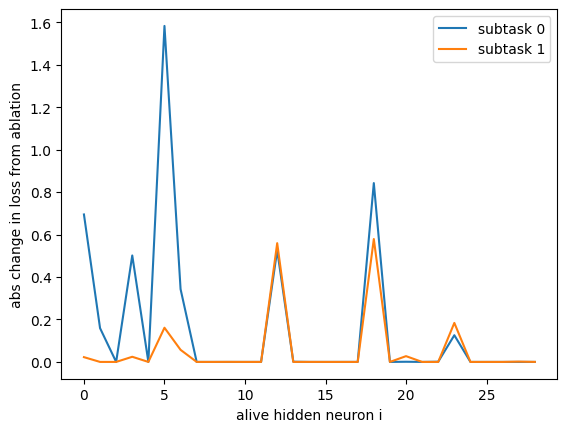

In [108]:
task0totask1 = np.argsort(scores)
plt.plot(np.array(ablation_scores[0])[task0totask1], label=f'subtask 0')
plt.plot(np.array(ablation_scores[1])[task0totask1], label=f'subtask 1')
plt.xlabel('alive hidden neuron i')
plt.ylabel('abs change in loss from ablation')
plt.legend()

In [109]:
args = argparse.Namespace()
args.n = 16
args.depth = 3
args.activation = "ReLU"
args.lr = 1e-3
args.layernorm = False
args.samples_per_task = 2000
args.steps = 10_000
args.verbose = True
args.seed = 0
args.device = "cuda" if torch.cuda.is_available() else "cpu"
args.dtype = "float32"

width_results = dict()

widths = [8, 16, 32, 64, 128, 256, 512, 1024]
for width in tqdm(widths):
    args.width = width
    Ss = [
        [0, 1, 2, 3],
        [4, 5, 6, 7],
    ]
    n_tasks = len(Ss)
    codes = [[i] for i in range(n_tasks)]
    train_sizes = [args.samples_per_task] * len(codes)

    def train():
        torch.manual_seed(args.seed)
        torch.cuda.manual_seed(args.seed)
        torch.cuda.manual_seed_all(args.seed)
        torch.backends.cudnn.deterministic = True

        if args.dtype == "float32":
            dtype = torch.float32
        else:
            dtype = torch.float64

        device = torch.device(args.device)

        if args.activation == "ReLU":
            activation_fn = nn.ReLU
        elif args.activation == "Tanh":
            activation_fn = nn.Tanh
        else:
            activation_fn = nn.Sigmoid

        layers = []
        for i in range(args.depth):
            if i == 0:
                if args.layernorm:
                    layers.append(nn.LayerNorm(n_tasks + args.n))
                layers.append(nn.Linear(n_tasks + args.n, args.width))
                layers.append(activation_fn())
            elif i == args.depth - 1:
                if args.layernorm:
                    layers.append(nn.LayerNorm(args.width))
                layers.append(nn.Linear(args.width, 2))
            else:
                if args.layernorm:
                    layers.append(nn.LayerNorm(args.width))
                layers.append(nn.Linear(args.width, args.width))
                layers.append(activation_fn())

        mlp = nn.Sequential(*layers).to(dtype).to(device)

        ps = sum(p.numel() for p in mlp.parameters())
        # print("Number of parameters:", ps)

        optimizer = torch.optim.Adam(mlp.parameters(), lr=args.lr, eps=1e-5)
        loss_fn = nn.CrossEntropyLoss()

        steps = []
        samples = []
        losses = []
        subtask_losses = defaultdict(list)

        for step in tqdm(range(args.steps), disable=not args.verbose):
            with torch.no_grad():
                for i, code in enumerate(codes):
                    x, y = get_batch(
                        n_tasks,
                        args.n,
                        Ss,
                        [code],
                        [train_sizes[i]],
                        device=device,
                        dtype=dtype,
                    )
                    y_pred = mlp(x)
                    subtask_losses[i].append(loss_fn(y_pred, y).item())

            x, y = get_batch(
                n_tasks, args.n, Ss, codes, train_sizes, device=device, dtype=dtype
            )
            y_pred = mlp(x)
            loss = loss_fn(y_pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            steps.append(step)
            losses.append(loss.item())
            samples.append(x.shape[0])

        results = {
            "steps": steps,
            "losses": losses,
            "subtask_losses": subtask_losses,
            "Ss": Ss,
            "codes": codes,
            "n_parameters": ps,
            "samples": samples,
        }

        return mlp, results, device, dtype, loss_fn

    width_results[width] = train()


100%|██████████| 8/8 [04:25<00:00, 33.22s/it]


There are 16 alive neurons: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


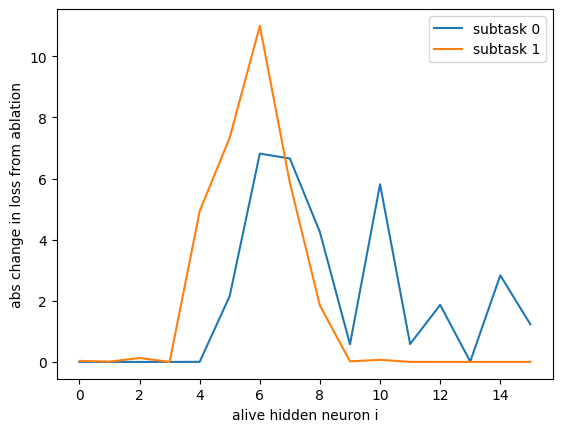

In [ ]:
width = 16
mlp, results, device, dtype, loss_fn = width_results[width]

ablation_scores = dict()
for i, code in enumerate(codes):
    x, y = get_batch(
        n_tasks,
        args.n,
        Ss,
        [code],
        [train_sizes[i]],
        device=device,
        dtype=dtype,
    )
    ablation_scores[i] = compute_ablation_scores(mlp, x, y, loss_fn)

alive_neurons = ((np.array(ablation_scores[0]) > 1e-4) | (np.array(ablation_scores[1]) > 1e-4)).nonzero()[0]
print(f"There are {len(alive_neurons)} alive neurons: {alive_neurons}")
scores = []
for neuroni in alive_neurons:
    scores.append(ablation_scores[0][neuroni] / ablation_scores[1][neuroni])
task0totask1 = np.argsort(scores)
plt.plot(np.array(ablation_scores[0])[task0totask1], label=f'subtask 0')
plt.plot(np.array(ablation_scores[1])[task0totask1], label=f'subtask 1')
plt.xlabel('alive hidden neuron i')
plt.ylabel('abs change in loss from ablation')
plt.legend()



Text(0, 0.5, 'count')

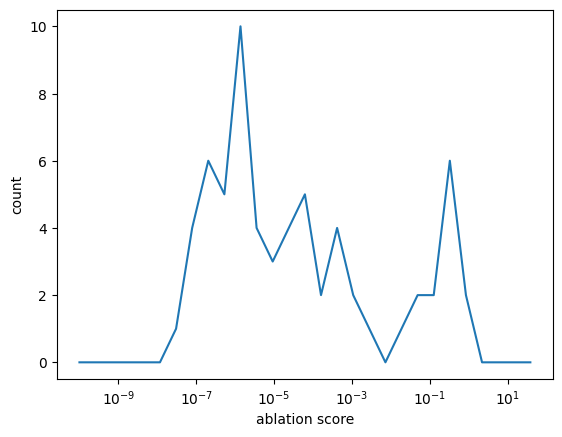

In [75]:
# plot the ablation_scores[0] with a log-scale histogram
hist, bin_edges = np.histogram(ablation_scores[0], bins=np.logspace(np.log10(1e-10), np.log10(1e2), 30))
plt.plot(bin_edges[:-1], hist)
plt.xscale('log')
plt.xlabel('ablation score')
plt.ylabel('count')
